In [73]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


In [47]:
sm.set_framework('tf.keras')

In [48]:
scaler = MinMaxScaler()

root_directory = 'data/semantic_drone_dataset/training_set'

patch_size = 256

In [49]:
def data_loader(folder_dir):
    # folder_dir = "../data/semantic_drone_dataset/training_set/images/"
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset


In [50]:
image_dataset = data_loader("../data/semantic_drone_dataset/training_set/images/")

In [51]:
mask_dataset = data_loader("../data/semantic_drone_dataset/training_set/gt/semantic/label_images/")

In [52]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [53]:
mask_dataset[1].shape

(128, 128, 3)

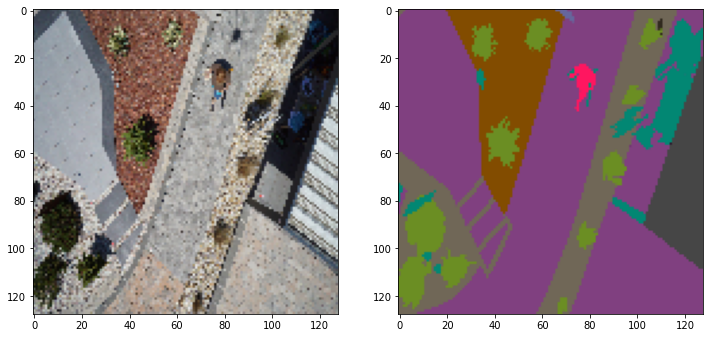

In [54]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [55]:
mask_labels = pd.read_csv('../data/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')

In [56]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [57]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    return label_seg

In [58]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [59]:
labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


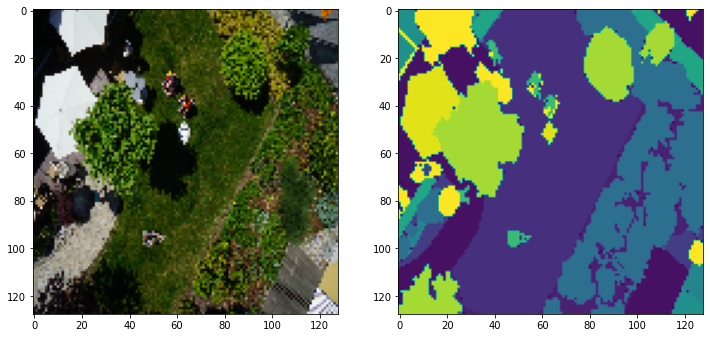

In [60]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [61]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [63]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [64]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [65]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [66]:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [67]:
model_resnet_backbone.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [68]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 [==============================] - 8s 122ms/step - loss: 2.5799 - accuracy: 0.3116 - val_loss: 151.3191 - val_accuracy: 0.3691
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 1.6527 - accuracy: 0.5741 - val_loss: 50.2997 - val_accuracy: 0.3557
Epoch 3/100
20/20 [==============================] - 2s 78ms/step - loss: 1.4046 - accuracy: 0.6155 - val_loss: 1355.9193 - val_accuracy: 0.3843
Epoch 4/100
20/20 [==============================] - 2s 76ms/step - loss: 1.2831 - accuracy: 0.6422 - val_loss: 82.5339 - val_accuracy: 0.5330
Epoch 5/100
20/20 [==============================] - 2s 77ms/step - loss: 1.2371 - accuracy: 0.6504 - val_loss: 2.7247 - val_accuracy: 0.4836
Epoch 6/100
20/20 [==============================] - 2s 77ms/step - loss: 1.2160 - accuracy: 0.6483 - val_loss: 1.9633 - val_accuracy: 0.5512
Epoch 7/100
20/20 [==============================] - 2s 77ms/step - loss: 1.2186 - accuracy: 0.6414 - val_loss: 20175.1602 - val_accuracy: 0

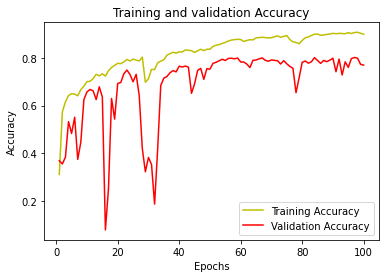

In [87]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [72]:
# model_resnet_backbone.save('../models/resnet_backbone.hdf5')

c:\DataScience\Python\machine_learning\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [74]:
model = load_model('../models/resnet_backbone.hdf5')

In [75]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [84]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

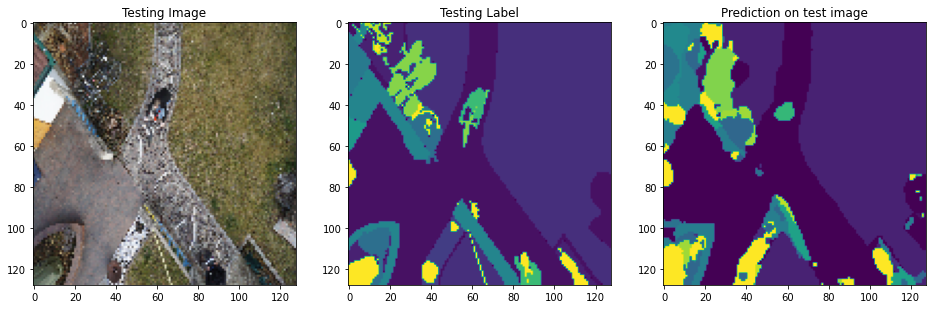

In [86]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()